# Task 1: Dimensionality Reduction

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


## Subtask 1: Data Loading and Data Preparation

In [2]:
# Fetching Labeled Faces in the Wild (LFW) dataset with minimum 30 faces per person and resizing images to 50%.
data_set = fetch_lfw_people(min_faces_per_person=30, resize=0.5)

# Extracting feature data (X) and target labels (y) from the LFW dataset
x = data_set.data  # Features representing the facial images
y = data_set.target  # Target labels corresponding to each facial image


In [3]:
print(f"There are {len(set(y))} different people in the data.")
print(f"There are {x.shape[0]} images in the data.")
print(f"The size of the images is {data_set.images[0].shape}.")


There are 34 different people in the data.
There are 2370 images in the data.
The size of the images is (62, 47).


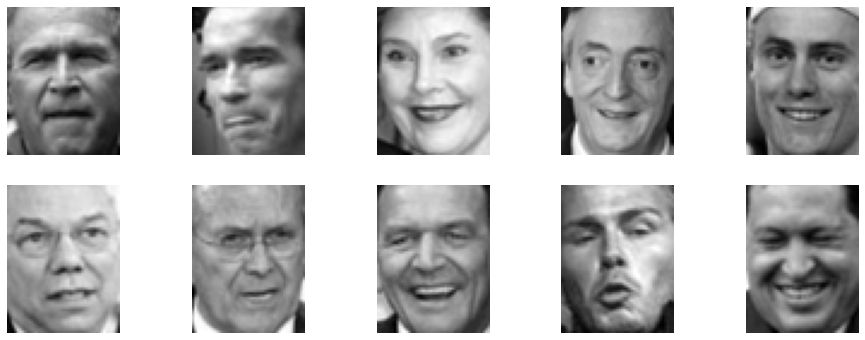

In [4]:
# Initializing a set to track unique person indices
unique_people_indices = set()

plt.figure(figsize=(16, 6))

for i in range(len(data_set.images)):
    # Extracting the person index for the current image
    person_index = y[i]
    
    # Checking if this person index is encountered for the first time
    if person_index not in unique_people_indices:
        unique_people_indices.add(person_index)
        plt.subplot(2, 5, len(unique_people_indices))
        plt.imshow(data_set.images[i], cmap='gray')
        plt.axis('off')
        
    if len(unique_people_indices) == 10:
        break

# Showing the 10 plotted images
plt.show()


In [5]:
# Test size for the train-test split as required
test_size = 0.3

# Splitting the data using a fixed random state for reproducibility, and stratifying to maintain class distribution in the splits
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=42, stratify=y)


## Subtask 2: Dimensionality Reduction Using PCA


In [6]:
class PCA:
    """
    Principal Component Analysis (PCA) class for dimensionality reduction.

    Parameters:
    - num_components (int): Number of principal components to retain.

    Attributes:
    - num_components (int): Number of principal components to retain.
    - mean (numpy.ndarray): Mean vector computed from the input data.
    - principal_components (numpy.ndarray): Matrix containing the principal components.

    Methods:
    - compute_PCA(x): Computes PCA on the input data and stores the mean and principal components.
    - project_data(x): Projects input data onto the principal components.
    - reconstruct_data(x): Reconstructs input data from its projection onto the principal components.
    """

    def __init__(self, num_components):
        """
        Initializes the PCA object with the specified number of principal components.

        Parameters:
        - num_components (int): Number of principal components to retain.
        """
        self.num_components = num_components
        self.mean = None
        self.principal_components = None
    
    def compute_PCA(self, x):
        """
        Computes PCA on the input data and stores the mean and principal components.

        Parameters:
        - x (numpy.ndarray): Input data for PCA.
        """
        self.mean = np.mean(x, axis=0)
        x -= self.mean

        covariance_matrix = np.cov(x, rowvar=False)

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        
        self.principal_components = eigenvectors[:, sorted_indices[:self.num_components]]

    def project_data(self, x):
        """
        Projects input data onto the principal components.

        Parameters:
        - x (numpy.ndarray): Input data to be projected.

        Returns:
        - x_projection (numpy.ndarray): Projected data.
        """
        x -= self.mean

        x_projection = np.dot(x, self.principal_components)
        
        return x_projection

    def reconstruct_data(self, x):
        """
        Reconstructs input data from its projection onto the principal components.

        Parameters:
        - x (numpy.ndarray): Projected data to be reconstructed.

        Returns:
        - reconstructed_data (numpy.ndarray): Reconstructed data.
        """
        return np.dot(x, self.principal_components.T) + self.mean


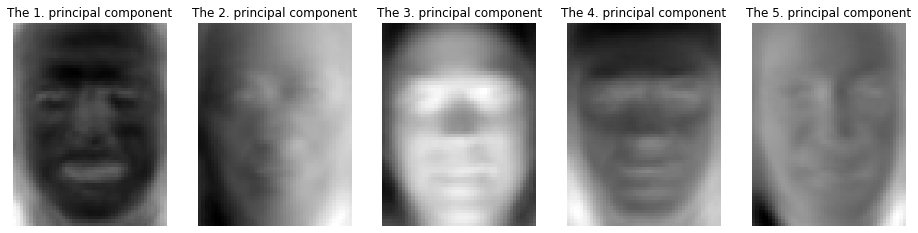

In [7]:
# Extracting image dimensions from the first image in the dataset
imagex, image_y = data_set.images[0].shape

d = 5

# Initializing PCA with 5 principal components
pca5 = PCA(d)

# Computing PCA on the training data
pca5.compute_PCA(x_train)

# Reshaping the principal components for visualization
principal_components = pca5.principal_components.T.reshape(-1, imagex, image_y)

# Plotting the 5 first principal components
plt.figure(figsize=(16, 6))
for i in range(d):
    plt.subplot(1, d, i + 1)
    plt.imshow(principal_components[i], cmap='gray')
    plt.title(f'The {i+1}. principal component')
    plt.axis('off')
plt.show()


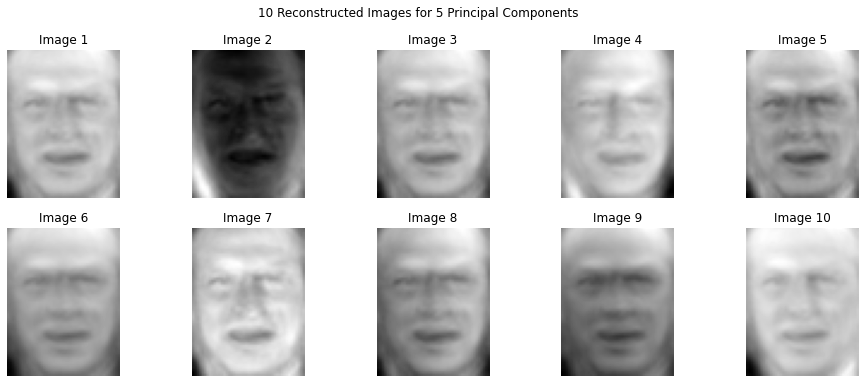

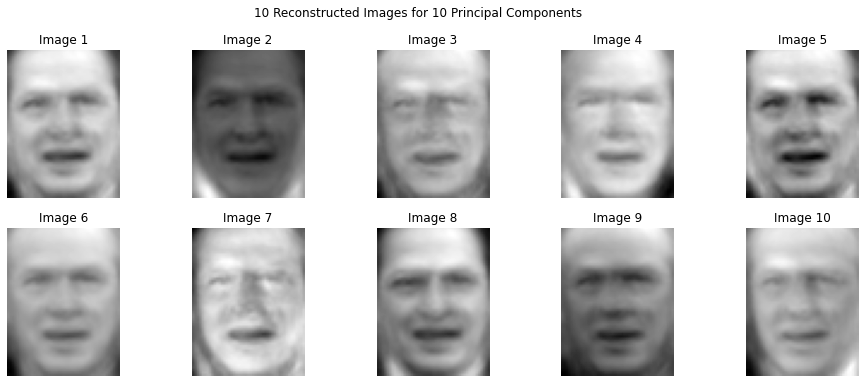

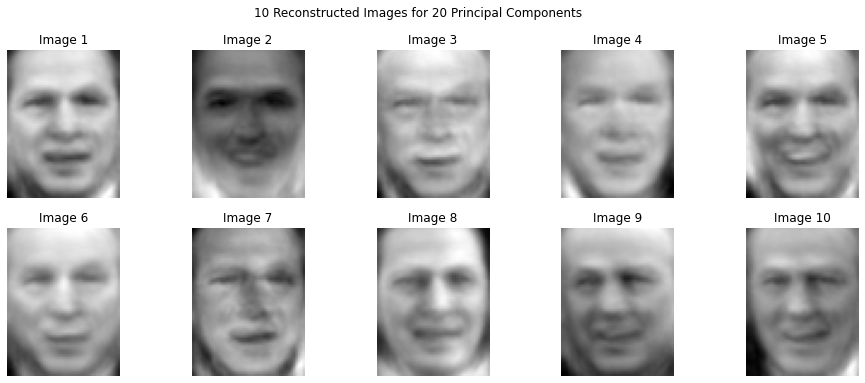

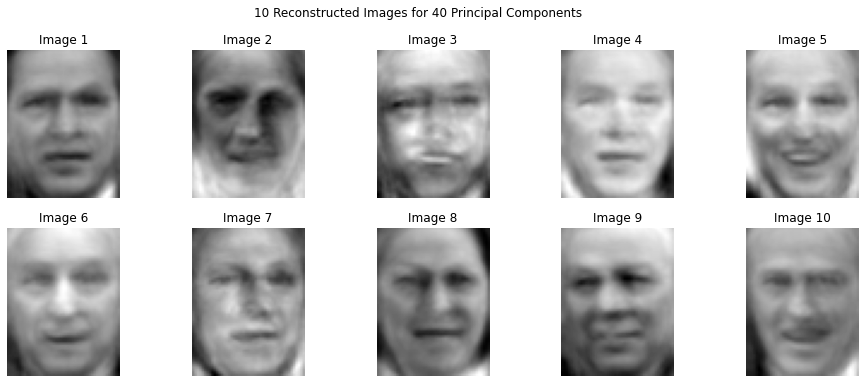

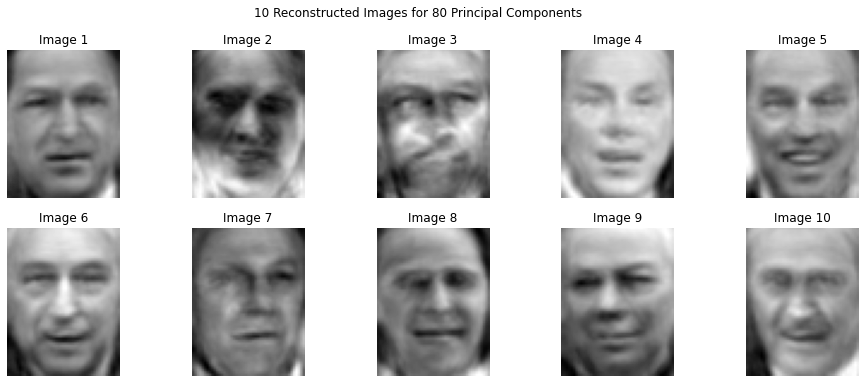

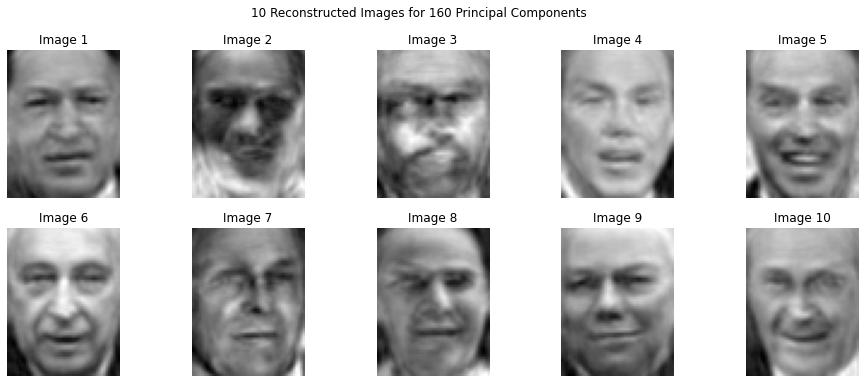

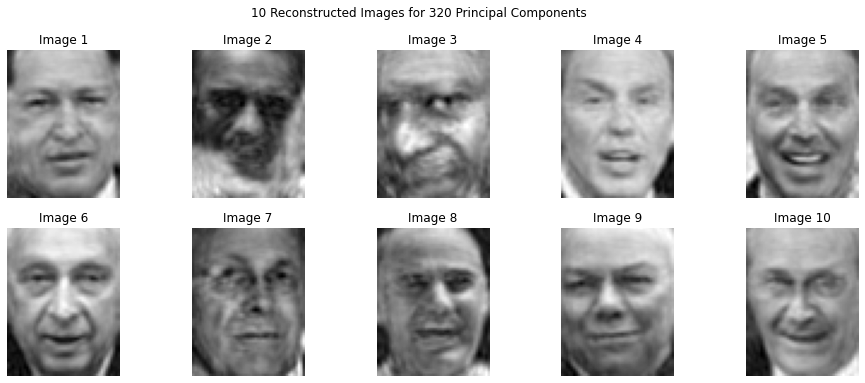

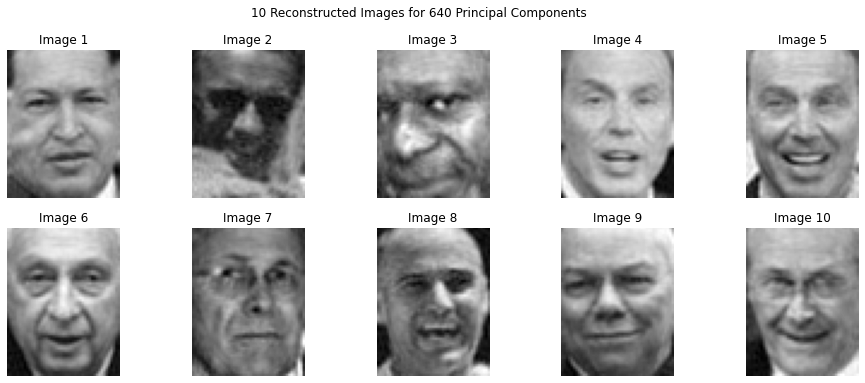

In [8]:
def plot_10_images(d):
    """
    Plots 10 reconstructed images using PCA with the specified number of principal components.

    Parameters:
    - d (int): Number of principal components for PCA.
    """
    # Initializing PCA with the specified number of principal components
    pcad = PCA(d)
    pcad.compute_PCA(x_train)
    
    # Projecting the validation data onto the principal components
    x_proj = pcad.project_data(x_val[:10])

    # Reconstructing the data from the projections and reshaping for visualization
    x_reconstructed = pcad.reconstruct_data(x_proj).reshape(-1, imagex, image_y)

    # Plotting the reconstructed images
    plt.figure(figsize=(16, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_reconstructed[i], cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.suptitle(f"10 Reconstructed Images for {d} Principal Components")
    plt.show()

# List of d values for principal components
d_values = [5, 10, 20, 40, 80, 160, 320, 640]
    
# Looping through each value of d and visualizing 10 reconstructed images
for d in d_values:
    plot_10_images(d)


In [9]:
# Lists to store training and validation accuracies for different values of d
train_accuracies = []
val_accuracies = []

# Initializing Min-Max scaler
scaler = MinMaxScaler()

# Looping through each value of d in the provided list
for d in d_values:
    
    # Initializing PCA with the specified number of principal components
    pcad = PCA(d)
    pcad.compute_PCA(x_train)
    
    # Projecting the training and validation data onto the principal components
    x_train_d = pcad.project_data(x_train)
    x_val_d = pcad.project_data(x_val)

    # Scaling the projected data using Min-Max scaler
    x_train_d = scaler.fit_transform(x_train_d)
    x_val_d = scaler.transform(x_val_d)

    # Initializing Logistic Regression model with a maximum of 1000 iterations and a fixed random state
    model = LogisticRegression(max_iter=1000, random_state=42)
    
    # Fitting the Logistic Regression model on the scaled and projected training data
    model.fit(x_train_d, y_train)

    # Predicting labels for the training and validation data
    y_train_pred = model.predict(x_train_d)
    y_val_pred = model.predict(x_val_d)

    # Calculating and storing training and validation accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


C:\Users\Botond\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


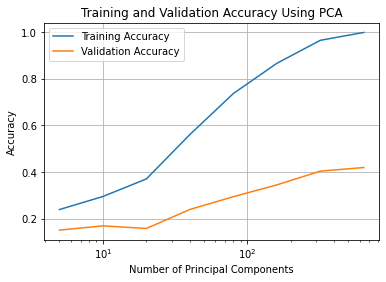

In [10]:
# Plotting training and validation accuracies against the number of principal components
plt.plot(d_values, train_accuracies, label='Training Accuracy')
plt.plot(d_values, val_accuracies, label='Validation Accuracy')

plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Using PCA')
plt.legend(loc='best')
plt.grid()
plt.xscale('log') 
plt.show()


Observing the results, it's evident that the training accuracy approaches 1 as the number of principal components increases, aligning with expectations. Although the accuracy on the validation data also shows improvement, it reaches a maximum around 40%.

## Subtask 3: Dimensionality Reduction Using Autoencoders


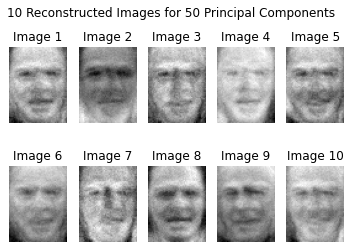

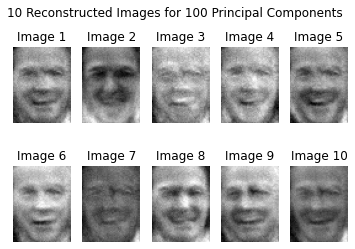

In [11]:
def encode(X, mlp):
    """
    This function is not working for general MLPs,
    the MLP must have the layer-configuration as
    stated in the exercise description.
    
    X must have the shape
    n_images x (witdh in pixels * height in pixels)
    """
    z = X
    for i in range(len(mlp.coefs_) // 2):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        z = np.maximum(z, 0)
    return z


def decode(Z, mlp):
    """
    This function is not working for general MLPs, the MLP
    must have the layer-configuration as stated in the
    exercise description.
    
    Z must have the shape n_images x d
    """
    z = Z
    for i in range(len(mlp.coefs_) // 2, len(mlp.coefs_)):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        if i < len(mlp.coefs_) - 1:
            z = np.maximum(z, 0)
    return z


def autoencoder(a, b, d):
    """
    Performs autoencoding using an MLPRegressor with specified architecture.

    Parameters:
    - a (int): Number of neurons in the first hidden layer.
    - b (int): Number of neurons in the second hidden layer.
    - d (int): Number of principal components.

    Returns:
    - x_decoded (numpy.ndarray): Decoded and reconstructed images.
    """
    # Defining the architecture of the autoencoder's hidden layers
    hidden_layer_sizes = (a, b, d, a, b)
    
    # Initializing MLPRegressor with ReLU activation and a fixed random state
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', max_iter=1000, random_state=42)
    
    # Fitting the autoencoder on the training data (input and output are the same for autoencoders)
    model.fit(x_train, x_train)
    
    # Encoding the validation data using the trained autoencoder
    x_encoded = encode(x_val, model)

    # Decoding the encoded data using the trained autoencoder
    x_decoded = decode(x_encoded, model)

    # Reshaping the decoded data for visualization
    x_decoded = x_decoded.reshape(-1, imagex, image_y)

    # Plotting 10 reconstructed images for visualization
    plt.suptitle(f'10 Reconstructed Images for {d} Principal Components')
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_decoded[i], cmap='gray')
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    plt.show()
    
    return x_decoded

# Example usage with d values 50 and 100
reconstructed_40 = autoencoder(a=300, b=200, d=50)
reconstructed_80 = autoencoder(a=300, b=200, d=100)



In [12]:
# Lists to store training and validation accuracies for different values of d
train_accuracies = []
val_accuracies = []

# Looping through each value of d in the provided list
for d in d_values:
    
    # Defining the architecture of the autoencoder's hidden layers
    hidden_layer_sizes = (300, 200, d, 300, 200)
    
    # Initializing MLPRegressor for autoencoding with ReLU activation and a fixed random state
    mlp_autoencoder = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', max_iter=1000, random_state=42)
    
    # Fitting the autoencoder on the training data (input and output are the same for autoencoders)
    mlp_autoencoder.fit(x_train, x_train)
    
    # Encoding the training and validation data using the trained autoencoder
    x_train_d = encode(x_train, mlp_autoencoder)
    x_val_d = encode(x_val, mlp_autoencoder)

    # Scaling the encoded data using Min-Max scaler
    x_train_d = scaler.fit_transform(x_train_d)
    x_val_d = scaler.transform(x_val_d)

    # Initializing Logistic Regression model with a maximum of 1000 iterations and a fixed random state
    model = LogisticRegression(max_iter=1000, random_state=42)
    
    # Fitting the Logistic Regression model on the scaled and encoded training data
    model.fit(x_train_d, y_train)

    # Predicting labels for the training and validation data
    y_train_pred = model.predict(x_train_d)
    y_val_pred = model.predict(x_val_d)

    # Calculating and storing training and validation accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


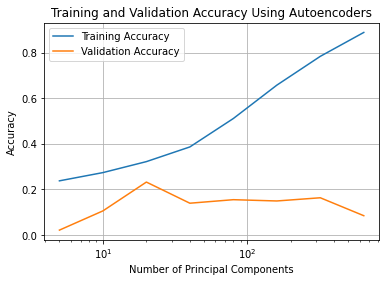

In [13]:
# Plotting training and validation accuracies against the number of principal components for autoencoders
plt.plot(d_values, train_accuracies, label='Training Accuracy')
plt.plot(d_values, val_accuracies, label='Validation Accuracy')

# Adding labels and title to the plot
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Using Autoencoders')

# Displaying the legend at the best location
plt.legend(loc='best')

# Adding a grid to enhance readability
plt.grid()

# Setting the x-axis to a logarithmic scale for better visualization
plt.xscale('log') 

# Displaying the plot
plt.show()


The training accuracy is similar when using PCA, it is constantly increasing, however it does not get close to 1. As of the validation accuracy, we can say that its performance is much worse in this case, as it is increasing with respect to the number of components and its maximum is also less, around 20%.

# **Task 2: Clustering**
## Subtask 1: Generate data


In [14]:
n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation) # Anisotropic blobs
X_varied, y_varied = make_blobs(
n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=
random_state
) # Unequal variance
X_filtered = np.vstack(
(X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
) # Unevenly sized blobs
y_filtered = [0] * 500 + [1] * 100 + [2] * 10


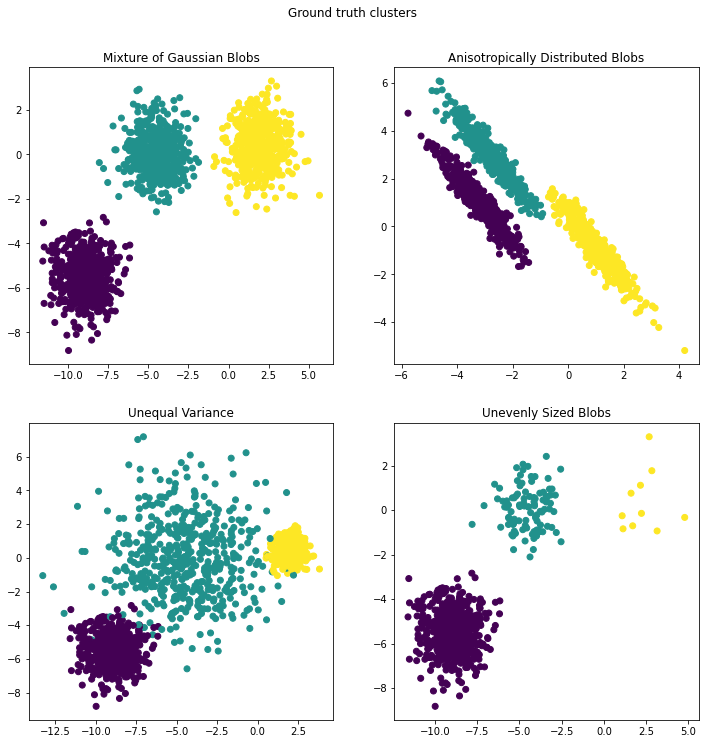

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axs[0, 0].set_title("Mixture of Gaussian Blobs")

axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
axs[1, 0].set_title("Unequal Variance")

axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.show()


## Subtask 2: Lloyd’s algorithm

In [32]:
def kmeans_plusplus_init(X, k, random_state=42):
    """
    Initializes k-means clustering centers using the k-means++ initialization.

    Parameters:
    - X (numpy.ndarray): Input data.
    - k (int): Number of clusters.
    - random_state (int): Seed for random number generation.

    Returns:
    - numpy.ndarray: Array containing the initialized cluster centers.
    """
    np.random.seed(random_state)
    centers = [X[np.random.choice(len(X))]]

    for _ in range(1, k):
        distances = pairwise_distances_argmin_min(X, centers, axis=1)[1]
        probabilities = distances / np.sum(distances)
        next_center_index = np.random.choice(len(X), p=probabilities)
        centers.append(X[next_center_index])

    return np.array(centers)


def lloyds_algorithm(X, k, max_iters=100, random_state=42, plusplus=False):
    """
    Applies Lloyd's algorithm for k-means clustering.

    Parameters:
    - X (numpy.ndarray): Input data.
    - k (int): Number of clusters.
    - max_iters (int): Maximum number of iterations.
    - random_state (int): Seed for random number generation.
    - plusplus (bool): If True, use k-means++ initialization.

    Returns:
    - tuple: Tuple containing cluster centers, labels, and inertia.
    """
    if plusplus:
        centers = kmeans_plusplus_init(X, k, random_state)
    else:
        np.random.seed(random_state)
        centers = X[np.random.choice(len(X), k, replace=False)]
    labels = None
    for _ in range(max_iters):
        # Assign each data point to the nearest cluster
        labels = pairwise_distances_argmin_min(X, centers, axis=1)[0]

        # Update cluster centers
        new_centers = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # If a cluster has no points assigned, reset its center randomly
        empty_clusters = np.where(np.isnan(new_centers).any(axis=1))[0]
        new_centers[empty_clusters] = X[np.random.choice(len(X), len(empty_clusters), replace=False)]

        # Check for convergence
        if np.all(centers == new_centers):
            break

        centers = new_centers
        
    inertia = np.sum(np.min(pairwise_distances_argmin_min(X, centers, axis=1)[1]))

    return centers, labels, inertia


def plot_clustering_results(x, k_values, i=1, plusplus=False):
    """
    Plots the clustering results for different k values.

    Parameters:
    - x (numpy.ndarray): Input data.
    - k_values (list): List of k values to experiment with.
    - i (int): Index of the dataset.
    - plusplus (bool): If True, use k-means++ initialization.
    """
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Clustering Results for Different k Values for the {i}. dataset")

    for j, k in enumerate(k_values, start=1):
        centers, labels, _ = lloyds_algorithm(x, k, plusplus=plusplus)

        plt.subplot(2, 3, j)
        plt.scatter(x[:, 0], x[:, 1], c=labels, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X')
        plt.title(f'K = {k}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

    plt.tight_layout()
    plt.show()
    

def plot_inertia(x, k_values, i=1, plusplus=False):
    """
    Plots the inertia values for different k values.

    Parameters:
    - x (numpy.ndarray): Input data.
    - k_values (list): List of k values to experiment with.
    - i (int): Index of the dataset.
    - plusplus (bool): If True, use k-means++ initialization.
    """
    inertias = []
    for k in k_values:
        _, _, inertia = lloyds_algorithm(x, k, plusplus=plusplus)
        inertias.append(inertia)

    plt.plot(k_values, inertias, marker='o')
    plt.title(f"K-Means Objective for Different k Values for the {i}. dataset")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.show()


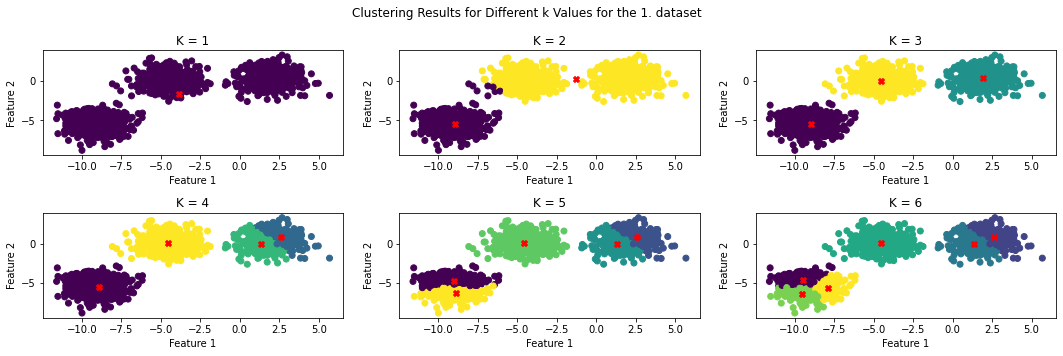

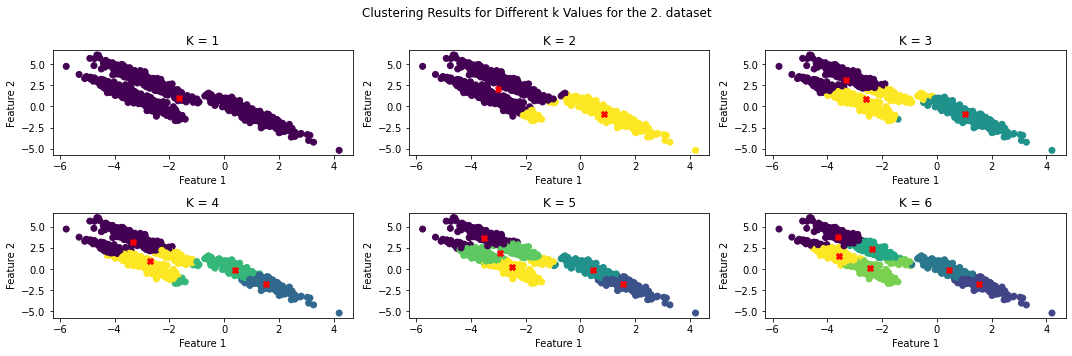

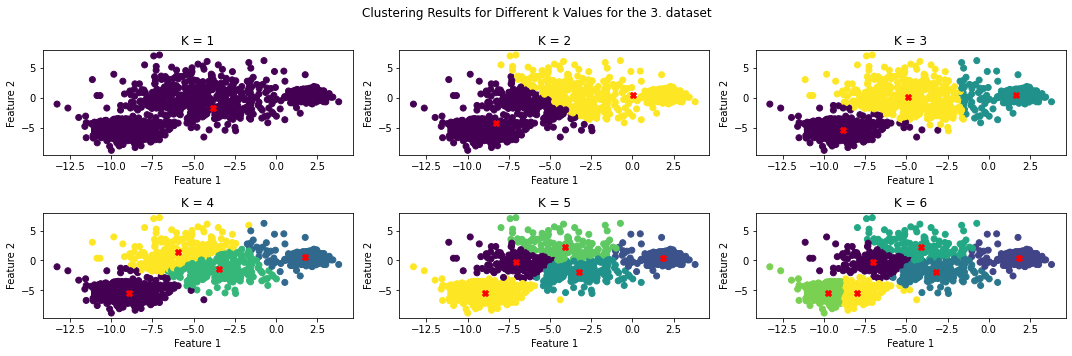

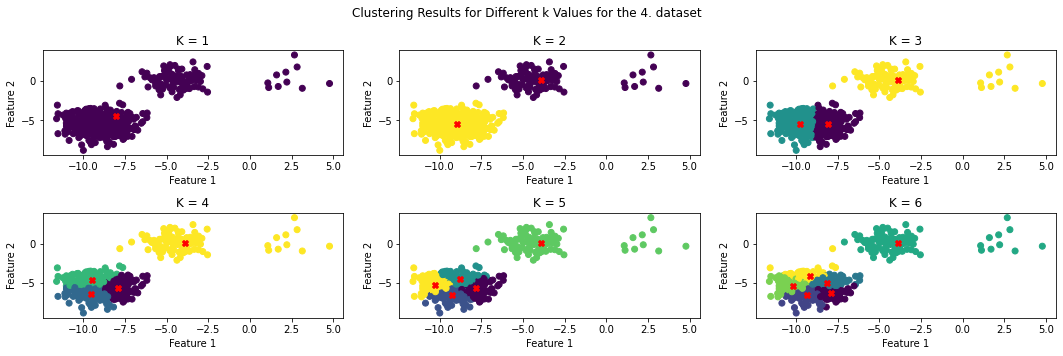

In [17]:
# List of k values for clustering experiments
k_values = [1, 2, 3, 4, 5, 6]

# Index for labeling datasets
i = 1

# Looping through different datasets and plotting clustering results
for dataset in [X, X_aniso, X_varied, X_filtered]:
    plot_clustering_results(dataset, k_values, i)
    i += 1


- What we can observe in the first two cases that the population of clusters is around equal.
- In the third case in the middle we have more dominant cluster or clusters, which include more datapoints than the ones on the edges.
- For the 4th dataset, we have points separated ,,in the upper right corner,, and they tend to stick together as one cluster.

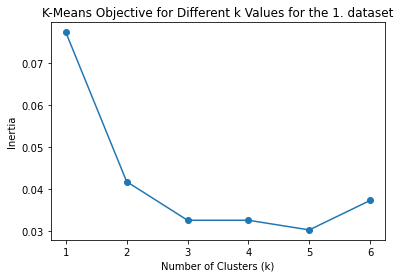

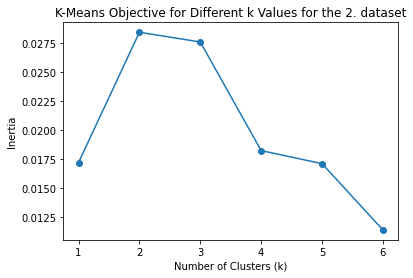

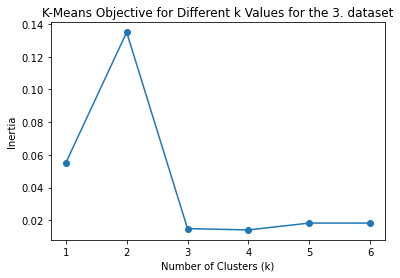

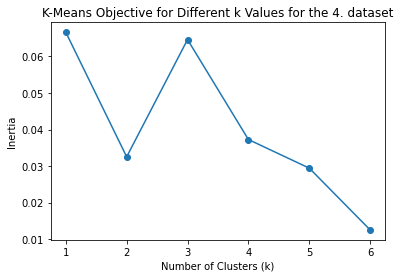

In [18]:
# Index for labeling datasets
i = 1

# Looping through different datasets and plotting inertia values
for dataset in [X, X_aniso, X_varied, X_filtered]:
    plot_inertia(dataset, k_values, i)
    i += 1


The objective function is not strictly decreasing as one would except in neither of the cases. However having the most clusters, 6 always seems a logical decision.

## Subtask 3: K-means++ initialization

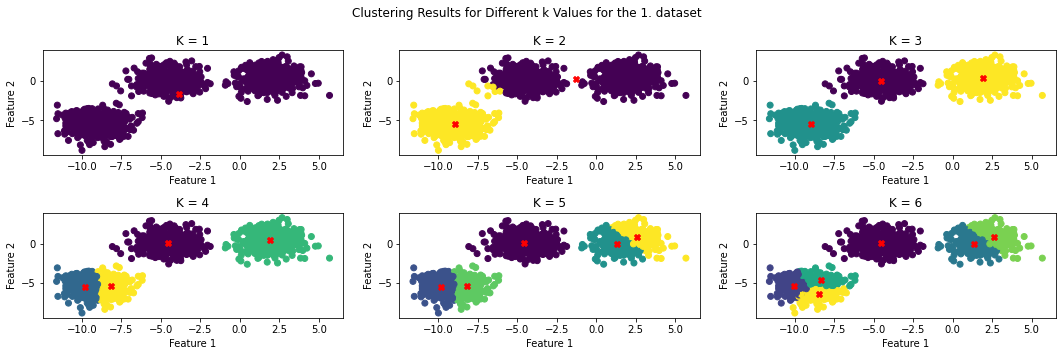

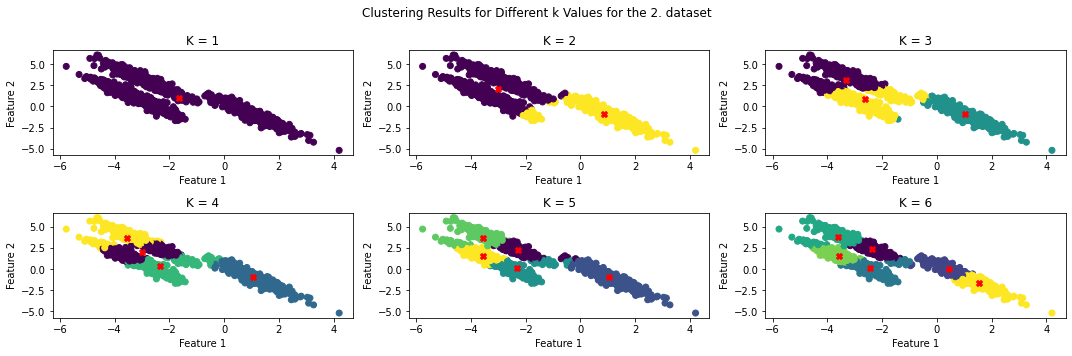

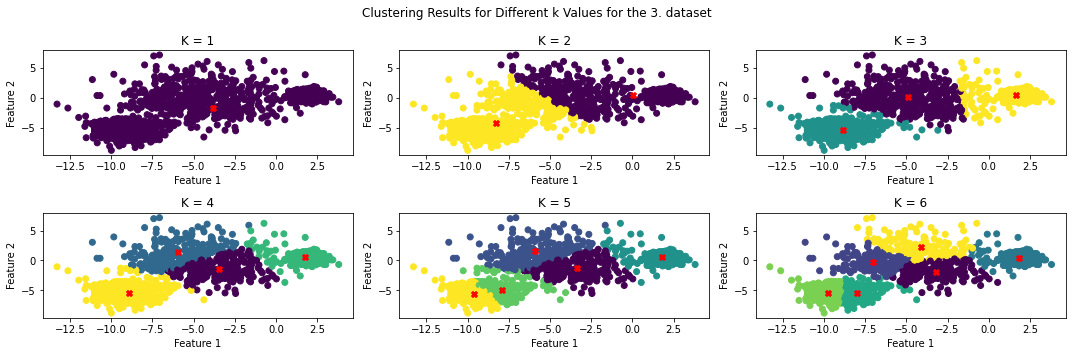

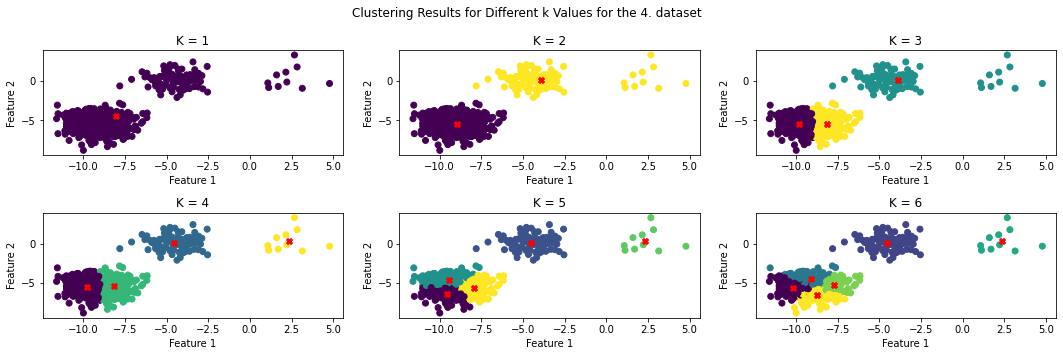

In [33]:
# Index for labeling datasets
i = 1

# Looping through different datasets and plotting clustering results with k-means++ initialization
for dataset in [X, X_aniso, X_varied, X_filtered]:
    plot_clustering_results(dataset, k_values, i, plusplus=True)
    i += 1


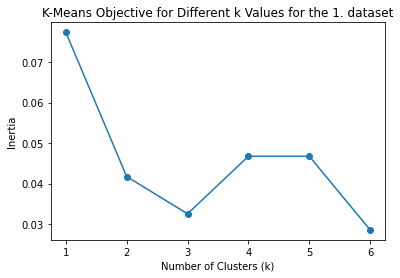

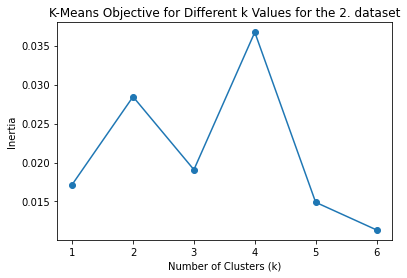

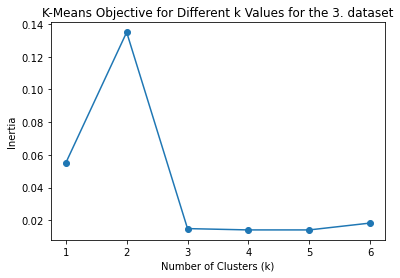

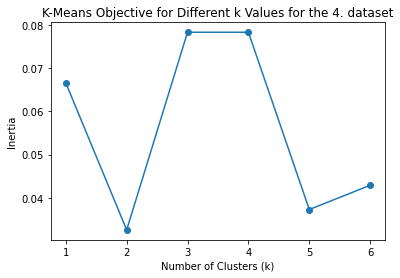

In [34]:
# Index for labeling datasets
i = 1

# Looping through different datasets and plotting inertia values with k-means++ initialization
for dataset in [X, X_aniso, X_varied, X_filtered]:
    plot_inertia(dataset, k_values, i, plusplus=True)
    i += 1


Notably, there are substantial differences in both the visual clustering patterns and the values of the objective function. This highlights the impact of the initial cluster centers on the model's behavior.
